# **Predicting House Prices Using Linear Regression ML Model**

We'll work with a dataset on sold houses in Ames, Iowa. Each row in the dataset describes the properties of a single house as well as the amount it was sold for. In this project, we'll build models that predict the final sale price from its other attributes using linear regression model of scikit-learn.

Originally, the dataset has:

- 82 columns (including target)
- 2930 rows 

Throughout this project, we will engineer new features from the original columns so much so that some of the models we'll build will have as much as 150 features (due attention on relevance with target column will be kept in mind at each step). 

Throoughout this project, we'll follow the following workflow pipeline:

  ![picture](https://drive.google.com/uc?export=view&id=16bnRoRoTpOY7wgyYaLovwz7julu39res)



1. As can been seen from the pipeline, we will build three functions where the **`transform_features()`** function will take the dataset as input. The function will perform cleaning of the available features. 

2. The output of first function, the cleaned/transformed dataset, will then be fed to another functoin called **`select_features()`**. This function will select important features from given data utilizing the Pearson correlation coefficient. The function will also engineer new columns from existing data by converting categorical columns to thier corresponding numerical dummy columns. `select_features()` function will be flexible enough let us experiment with different features depending upon the extent of their relation with the target column. Moroever, the function will also allow us to engineer columns depending upon the number of unique values in each categorical column.

3. Once implemented, `select_features()` function will give us an output dataframe that will be both transformed and engineered. This output will then be fed into **`train_and_test()`** function. This function will give us our desired output in form of Root Mean Square Error **(RMS)**.
`train_and_test()` function will be flexible enough to allow us to try different validation techniques such as test/train, holdout, and k-fold validations. 

Let's begin by importing all the packages we would need!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Let's read the data set to get a feel of it!

In [2]:
data= pd.read_csv('AmesHousing.tsv', delimiter='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Workflow Implementation — Initial

Let's now:
1. Create a function named **transform_features()** that, for now, just returns the data frame it take in as input.

2. Create a function named **select_features()** that, for now, just returns the Gr Liv Area and SalePrice columns from the data frame it gets as input.

3. Create a function named **train_and_test()** that, for now:
  - Selects the first 1460 rows from from data frame and assign to train.
  - Selects the remaining rows from data frame and assign to test.
  - Trains a model using all numerical columns except the SalePrice column (the target column) from the data frame 
  - Tests the model on the test set and returns the RMSE value.



**With every step that follows, we will just refine these three functions with a goal to minimzie RMSE of our model!**

In [3]:
def transform_features(df):
    return df

# Only one feature initially
def select_features(df):
    features = ['Gr Liv Area','SalePrice']
    return df[features]

def train_and_test(df):
    train=df.iloc[:1460]
    test=df.iloc[1460:]
    
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test= test.select_dtypes(include=['integer','float'])
    
    attributes= numeric_train.columns.drop('SalePrice')
    target='SalePrice'
    
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions=lr.predict(test[attributes])
    
    mse= mean_squared_error(test[target],predictions)
    rmse=mse**(1/2)
    return rmse

transformed_features= transform_features(data)
selected_features= select_features(transformed_features)
rmse= train_and_test(selected_features)
rmse

57088.25161263909

## Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. Update transform_features() so that any column/s from the data frame with more than 5% (or another cutoff value) missing values is dropped. Also, let's remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

- remove features that we don't want to use in the model, just based on the number of missing values or data leakage

- transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)

- create new features by combining other features

**Let's first try these transformations separately before implementing them into our transform_features() function**

In [4]:
# getting columns having more than 5% of missing values
mv_cols_5_per = data.isnull().sum()[data.isnull().sum()>1/20*len(data)].index

In [5]:
#dropping columns with more than 5% of missing values
print('original columns count:{}'.format(len(data.columns)))
data.drop(mv_cols_5_per,axis=1,inplace=True)
print('remaining columns:{}'.format(len(data.columns)))

original columns count:82
remaining columns:71


In [6]:
# getting text columns 
non_numeric_cols = data.select_dtypes(include=['object']).columns
#checking number of missing values in each text column
mv_count_text_series=data[non_numeric_cols].isnull().sum() #this is a series object
#removing all the text columns which have 1 or more missing value
mv_text_cols=mv_count_text_series[mv_count_text_series!=0].index
data.drop(mv_text_cols,axis=1,inplace=True)
print('remaining columns:{}'.format(len(data.columns)))

remaining columns:64


In [7]:
#numerical columns missing values (remember there will be cols where mmv<5% of total values)
numeric_series=data.select_dtypes(include=['integer','float']).isnull().sum()
mv_numeric_series=numeric_series[numeric_series!=0]
mv_numeric_series.sort_values()

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [8]:
mv_numeric_cols=mv_numeric_series.index.tolist()
data[mv_numeric_cols]

,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Cars,Garage Area
0,112.0,639.0,0.0,441.0,1080.0,1.0,0.0,2.0,528.0
1,0.0,468.0,144.0,270.0,882.0,0.0,0.0,1.0,730.0
2,108.0,923.0,0.0,406.0,1329.0,0.0,0.0,1.0,312.0
3,0.0,1065.0,0.0,1045.0,2110.0,1.0,0.0,2.0,522.0
4,0.0,791.0,0.0,137.0,928.0,0.0,0.0,2.0,482.0
...,...,...,...,...,...,...,...,...,...
2925,0.0,819.0,0.0,184.0,1003.0,1.0,0.0,2.0,588.0
2926,0.0,301.0,324.0,239.0,864.0,1.0,0.0,2.0,484.0
2927,0.0,337.0,0.0,575.0,912.0,0.0,1.0,0.0,0.0
2928,0.0,1071.0,123.0,195.0,1389.0,1.0,0.0,2.0,418.0


Above dataframe shows that it is sensible to replace missing values in some columns with the column's mean (BsmtFin SF1, for example).
On the other hand, there are some columns (Garage cars) for which replacing missing values with the column's mode makes more sense. Let's keep the above df in mind and proceed with replacing the missing values.

In [9]:
mode_cols=['Mas Vnr Area','Bsmt Full Bath','Bsmt Half Bath','Garage Cars']
mean_cols=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
           'Garage Area']

#fillling missing values for selected columns with column mode
data[mode_cols]=data[mode_cols].fillna(data[mode_cols].mode)
#fillling missing values for selected columns with column mean
data[mean_cols]=data[mean_cols].fillna(data[mean_cols].mean())

data[mv_numeric_cols].isnull().sum()

Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Cars       0
Garage Area       0
dtype: int64

In [10]:
# confirming that data has no missing value
data.isnull().sum().value_counts()

0    64
dtype: int64

In [11]:
# Engineering new columns from existing discrete cols
age_at_sale = data['Yr Sold'] - data['Year Built']
# checking for implausoible values
age_at_sale[age_at_sale<0]

2180   -1
dtype: int64

In [12]:
years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
# checking for implausible values
years_since_remod[years_since_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [13]:
# adding new columns to dataframe
data['age_at_sale']= age_at_sale
data['years_since_remod']= years_since_remod
# Removing rows from dataframe that have negative values for engineered cols
data.drop([2180,1702,2181],axis=0,inplace=True)
# Removing redundant cols
data.drop(["Year Built", "Year Remod/Add"],axis=1,inplace=True)
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,age_at_sale,years_since_remod
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,Hip,CompShg,BrkFace,Plywood,112,TA,TA,CBlock,639.0,0.0,441.0,1080.0,GasA,Fa,Y,1656,0,0,1656,1,0,1,0,3,1,TA,7,Typ,2,2,528.0,P,210,62,0,0,0,0,0,5,2010,WD,Normal,215000,50,50
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,0,TA,TA,CBlock,468.0,144.0,270.0,882.0,GasA,TA,Y,896,0,0,896,0,0,1,0,2,1,TA,5,Typ,0,1,730.0,Y,140,0,0,0,120,0,0,6,2010,WD,Normal,105000,49,49
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,108,TA,TA,CBlock,923.0,0.0,406.0,1329.0,GasA,TA,Y,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,1,312.0,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal,172000,52,52
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,Hip,CompShg,BrkFace,BrkFace,0,Gd,TA,CBlock,1065.0,0.0,1045.0,2110.0,GasA,Ex,Y,2110,0,0,2110,1,0,2,1,3,1,Ex,8,Typ,2,2,522.0,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,244000,42,42
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,0,TA,TA,PConc,791.0,0.0,137.0,928.0,GasA,Gd,Y,928,701,0,1629,0,0,2,1,3,1,TA,6,Typ,1,2,482.0,Y,212,34,0,0,0,0,0,3,2010,WD,Normal,189900,13,12


In [14]:
# Removing insignificant columns
data.drop(['Order','PID'],axis=1,inplace=True)

# Removing columns that leak information about the sale
data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"],
         axis=1,inplace=True)

print(data.shape)

(2927, 58)


### Updating transform_features() function

Let's now all steps from cell#6 to cell#16 into our transform_features() function to update it.

In [15]:
def transform_features(df):
    
    # getting columns having more than 5% of missing values
    mv_cols_5_per = df.isnull().sum()[df.isnull().sum()>1/20*len(df)].index
    #dropping columns with more than 5% of missing values
    df.drop(mv_cols_5_per,axis=1,inplace=True)
    
    # getting text columns 
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    #checking number of missing values in each text column
    mv_count_text_series=df[non_numeric_cols].isnull().sum() #this is a series object
    #removing all the text columns which have 1 or more missing value
    mv_text_cols=mv_count_text_series[mv_count_text_series!=0].index
    df.drop(mv_text_cols,axis=1,inplace=True)
    
    #numerical columns missing values adjustment
    #remember there will be cols where mv<5% of total values
    numeric_series=data.select_dtypes(include=['integer','float']).isnull().sum()
    mv_numeric_series=numeric_series[numeric_series!=0]
    mv_numeric_cols=mv_numeric_series.index.tolist()
    mode_cols=['Mas Vnr Area','Bsmt Full Bath','Bsmt Half Bath',
               'Garage Cars']
    mean_cols=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
           'Garage Area']
    #fillling missing values for selected columns with column mode
    data[mode_cols]=data[mode_cols].fillna(data[mode_cols].mode)
    #fillling missing values for selected columns with column mean
    data[mean_cols]=data[mean_cols].fillna(data[mean_cols].mean())

    
    # Engineering new columns from existing discrete cols
    age_at_sale = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    # adding new columns to dfframe
    df['age_at_sale']= age_at_sale
    df['years_since_remod']= years_since_remod
    # Removing rows from dfframe that have negative values for engineered cols
    df.drop([2180,1702,2181],axis=0,inplace=True)
    # Removing redundant cols
    df.drop(["Year Built", "Year Remod/Add"],axis=1,inplace=True)
    
    # Removing insignificant columns
    df.drop(['Order','PID'],axis=1,inplace=True)

    # Removing columns that leak information about the sale
    df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"],
         axis=1,inplace=True)
    
    return df

def select_features(df):
    features = ['Gr Liv Area','SalePrice']
    return df[features]

def train_and_test(df):
    train=df.iloc[:1460]
    test=df.iloc[1460:]
    
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test= test.select_dtypes(include=['integer','float'])
    
    attributes= numeric_train.columns.drop('SalePrice')
    target='SalePrice'
    
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions=lr.predict(test[attributes])
    
    mse= mean_squared_error(test[target],predictions)
    rmse=mse**(1/2)
    return rmse

#Rereading to use original dataframe for transformation function
data= pd.read_csv('AmesHousing.tsv', delimiter='\t')

# Calling functions
transformed_features= transform_features(data)
selected_features= select_features(transformed_features)
rmse= train_and_test(selected_features)
rmse

55275.36731241307

We can see how reducing the noise of our data reduced RMSE by around 2000 as we used updated transformed_features() function. We will continue to deploy other strategies to reduce RMSE as much as we can.

## Feature Selection
Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.


### Developing Correlations
Which numerical features correlate strongly with our target column, SalePrice? Let's find out by generating a heat map that plots the correlations between all the numerical columns using Pearson coefficient (where, 0 <Pearson coef <1). Remember, we are interested, at this point, [link text](https://) to find out how strongly SalePrice (target) column relates with other numerical columns.

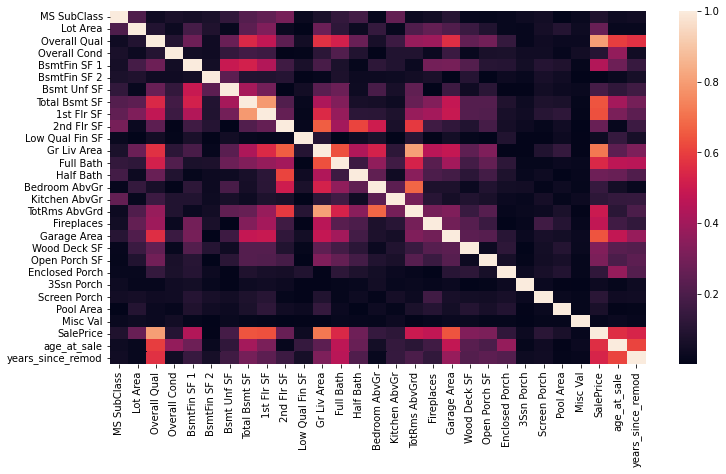

In [16]:
# Segregating numerical features
numeric_cols=data.select_dtypes(include=['integer','float']).columns
# Developing correlations bw numerical columns
numeric_correlations=data[numeric_cols].corr().abs() # abs() will convert negative correlaations to positve ones 
# Picking correlations bw SalePrice and all other numerical columns
saleprice_corr=numeric_correlations.iloc[-3,0:]
# Picking weak SalePrice/numeric-columns correlations
weak_corr=saleprice_corr[(saleprice_corr>0.3)].index.tolist() # we will experiment by changing 0.4(correlation coeff) later on
# Dropping weak correaltions
transformed_features.drop(weak_corr,axis=1,inplace=True)
plt.figure(figsize=(12,6.5))
sns.heatmap(numeric_correlations)
plt.show()

We can see from the above heatmap that `SalePrice` is strongly related to few numerical columns/features such as:

- `Gr Liv Area`
- `Overall Qual`
- `Garage Area`


### Converting Nominal Features to Categorical

Which columns in the data frame should be converted to the categorical data type? All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. Let's use [information](https://s3.amazonaws.com/dq-content/307/data_description.txt) about data to dig out nominal columns.

Once selected, we will make decision on converting which nominal columnsto categorical form makes and will later generate dummies for them. Following considerations will be important to guide this process:

  - If a categorical column has hundreds of unique values (or categories), should you keep it? In such case, while dummy coding this column, hundreds of columns will need to be added back to the data frame. So, we will skip nominal columns that have way too much unique values.

  - If categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category, this would be similar to a low variance numerical feature (no variability in the data for the model to capture) and ,hence, we will skip such features too.

In [17]:
## Create a list of column names from documentation that are *meant* to be categorical
nominal_features = list(["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"])

In [18]:
# let's see how many of nominal_features we have in our transformed_features data frame
cat_cols_in_transformed=[]
for col in transformed_features.columns:
  if col in nominal_features:
    cat_cols_in_transformed.append(col)

## Let's see how many unique values are there in each nominal column of transformed_features df
uniqueness_counts = transformed_features[cat_cols_in_transformed].apply(lambda col:len(col.value_counts()))
uniqueness_counts.sort_values()

Central Air      2
Street           2
Land Contour     4
Lot Config       5
Bldg Type        5
Heating          6
Roof Style       6
Foundation       6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
MS SubClass     16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [19]:
# let's for now drop all categorical columns that have more than 10 unique values as 
#they will lead to the problem of excessive dummy cols (we'll experiment with this threshold)

transformed_features.drop(uniqueness_counts[uniqueness_counts>10].index,axis=1,inplace=True)
transformed_features.shape


(2927, 40)

In [20]:
# in the transformed_features df, there are object type columns other than those in nominal_features list
# let's keep only those for now, where unique values are less than 10 to avoid dummy cols problem
object_cols=transformed_features.select_dtypes(include=['object'])
remaining_cat_cols=[]
for col in object_cols:
  if col not in cat_cols_in_transformed:
    remaining_cat_cols.append(col)

# calculating unique values in remaining_cat_cols
unique_values=transformed_features[remaining_cat_cols].apply(lambda col:len(col.value_counts()))
print(unique_values)
# dropping columns from remaining_cat_cols where unqiue values are greater than 10
more_than_10=unique_values[unique_values>10].index
transformed_features.drop(more_than_10,axis=1,inplace=True)

Lot Shape           4
Utilities           3
Land Slope          3
Mas Vnr Area      445
Exter Qual          4
Exter Cond          5
Heating QC          5
Bsmt Full Bath      5
Bsmt Half Bath      4
Kitchen Qual        5
Functional          8
Garage Cars         7
Paved Drive         3
dtype: int64


In [21]:
# Let's now create dummies for kept category columns

updated_object_cols=transformed_features.select_dtypes(include=['object'])

for col in updated_object_cols.columns.tolist():
  transformed_features[col]=transformed_features[col].astype(str) #idk direct category conversion raised error
  transformed_features[col]=transformed_features[col].astype('category')

# creating dummy cols for category type cols and concatenating them original df
transformed_features=pd.concat([transformed_features,
            pd.get_dummies(transformed_features.select_dtypes(include=['category']))
            ], axis=1)

# Removing initial obj_cols
transformed_features.drop(updated_object_cols,axis=1,inplace=True)
transformed_features.shape

(2927, 146)

### Updating select_features() function



In [22]:
def transform_features(df):
    
    # getting columns having more than 5% of missing values
    mv_cols_5_per = df.isnull().sum()[df.isnull().sum()>1/20*len(df)].index
    #dropping columns with more than 5% of missing values
    df.drop(mv_cols_5_per,axis=1,inplace=True)
    
    # getting text columns 
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    #checking number of missing values in each text column
    mv_count_text_series=df[non_numeric_cols].isnull().sum() #this is a series object
    #removing all the text columns which have 1 or more missing value
    mv_text_cols=mv_count_text_series[mv_count_text_series!=0].index
    df.drop(mv_text_cols,axis=1,inplace=True)
    
    #numerical columns missing values adjustment
    #remember there will be cols where mv<5% of total values
    numeric_series=data.select_dtypes(include=['integer','float']).isnull().sum()
    mv_numeric_series=numeric_series[numeric_series!=0]
    mv_numeric_cols=mv_numeric_series.index.tolist()
    mode_cols=['Mas Vnr Area','Bsmt Full Bath','Bsmt Half Bath',
               'Garage Cars']
    mean_cols=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
           'Garage Area']
    #fillling missing values for selected columns with column mode
    data[mode_cols]=data[mode_cols].fillna(data[mode_cols].mode)
    #fillling missing values for selected columns with column mean
    data[mean_cols]=data[mean_cols].fillna(data[mean_cols].mean())

    
    # Engineering new columns from existing discrete cols
    age_at_sale = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    # adding new columns to dfframe
    df['age_at_sale']= age_at_sale
    df['years_since_remod']= years_since_remod
    # Removing rows from dfframe that have negative values for engineered cols
    df.drop([2180,1702,2181],axis=0,inplace=True)
    # Removing redundant cols
    df.drop(["Year Built", "Year Remod/Add"],axis=1,inplace=True)
    
    # Removing insignificant columns
    df.drop(['Order','PID'],axis=1,inplace=True)

    # Removing columns that leak information about the sale
    df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"],
         axis=1,inplace=True)
    
    return df
    

##### Updating select_features() in light of experimentation in Feature selection section

def select_features(df,corr_coef=0.4,cat_threshold=10):
  # Segregating numerical features
  numeric_cols=df.select_dtypes(include=['integer','float']).columns
  # Developing correlations bw numerical columns
  numeric_correlations=df[numeric_cols].corr().abs() # abs() will convert negative correlaations to positve ones 
  # Picking correlations bw SalePrice and all other numerical columns
  saleprice_corr=numeric_correlations.iloc[-3,0:]
  # Picking strong SalePrice/numeric-columns correlations
  weak_corr=saleprice_corr[(saleprice_corr<corr_coef)].index.tolist() # we will experiment by changing corr coeff later on
  df=df.drop(weak_corr,axis=1)
  
  ## Create a list of column names from documentation that are meant to be categorical
  nominal_features = list(["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"])
  
  # let's see how many of nominal_features we have in our transformed_features data frame
  cat_cols_in_df=[]
  for col in df.columns:
    if col in nominal_features:
      cat_cols_in_df.append(col)

  ## Let's see how many unique values are there in each nominal column of transformed_features df
  uniqueness_counts = df[cat_cols_in_df].apply(lambda col:len(col.value_counts()))
  
  # drop all categorical columns that have more than 'cat_threshold' unique values as 
  #they will lead to the problem of excessive dummy cols (we'll experiment with this threshold)
  df.drop(uniqueness_counts[uniqueness_counts>cat_threshold].index,axis=1,inplace=True)

  object_cols=df.select_dtypes(include=['object'])
  remaining_cat_cols=[]
  for col in object_cols:
    if col not in cat_cols_in_df:
      remaining_cat_cols.append(col)

  # calculating unique values in remaining_cat_cols
  unique_values=df[remaining_cat_cols].apply(lambda col:len(col.value_counts()))
  # dropping columns from remaining_cat_cols where unqiue values are greater than cat_threshold
  more_than_thresh=unique_values[unique_values>cat_threshold].index
  df.drop(more_than_thresh,axis=1,inplace=True)
  
  # Changing desired object columns to category type
  updated_object_cols=df.select_dtypes(include=['object'])
  for col in updated_object_cols.columns.tolist():
    df[col]=df[col].astype(str) #idk direct category conversion raised error
    df[col]=df[col].astype('category')

  # creating dummy cols for category type cols and concatenating them original df
  df_=pd.concat([df,
                pd.get_dummies(df.select_dtypes(include=['category']))
              ], axis=1)

  # Removing initial obj_cols
  df=df_.drop(updated_object_cols.columns,axis=1)
  # Changing dummy cols datatype from uint8 to int
  uint_type_cols= df.select_dtypes(include='uint8').columns
  df[uint_type_cols]=df[uint_type_cols].astype(int)
  return df

    
def train_and_test(df):
    train=df.iloc[:1460]
    test=df.iloc[1460:]
    
    numeric_train=train.select_dtypes(include=['integer','float'])
    numeric_test= test.select_dtypes(include=['integer','float'])
    
    attributes= numeric_train.columns.drop('SalePrice')
    target='SalePrice'
    
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions=lr.predict(test[attributes])
    
    mse= mean_squared_error(test[target],predictions)
    rmse=mse**(1/2)
    return rmse

#Rereading to use original dataframe for transformation function
data= pd.read_csv('AmesHousing.tsv', delimiter='\t')

# Calling functions
transformed_features= transform_features(data)
# remember to give corr coeff and cat_threshold to select_features apart from df 
selected_features= select_features(transformed_features)
rmse= train_and_test(selected_features)
rmse

32585.521260997113

## Train and Test

Now let's move to the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named k that controls the type of cross validation that occurs.

1. The optional k parameter should accept integer values, with a default value of 0 (**train/test validation**)
  - When k equals 0, perform holdout validation (what we already implemented):
  - Select the first 1460 rows and assign to train.
  - Select the remaining rows and assign to test.
  - Train on train and test on test.
  - Compute the RMSE and return.
2. When k equals 1, perform simple cross validation (**holdout validation**)
  - Shuffle the ordering of the rows in the data frame.
  - Select the first 1460 rows and assign to fold_one.
  - Select the remaining rows and assign to fold_two.
  - Train on fold_one and test on fold_two.
  - Train on fold_two and test on fold_one.
  - Compute the average RMSE and return. 
3. When k is greater than 1, implement k-fold cross validation using k folds (**k-fold validation**)
  - Perform k-fold cross validation using k folds.
  - Calculate the average RMSE value and return this value.

In [23]:
def train_and_test(df,k=0):
  
  #train/test validation
  if k==0:
    numeric_df=df.select_dtypes(include=['integer','float'])
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    train=numeric_df.iloc[:1460]
    test=numeric.iloc[1460:]
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions=lr.predict(test[attributes])
    mse= mean_squared_error(test[target],predictions)
    rmse=mse**(1/2)
    return rmse
  #holdout validation
  if k==1:
    # generating a random array having 2926 indices
    indices = np.random.permutation(2927)
    df=df.iloc[indices]
    numeric_df=df.select_dtypes(include=['integer','float'])
    train=numeric_df.iloc[:1460]
    test=numeric.iloc[1460:]
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions_1=lr.predict(test[attributes])
    mse= mean_squared_error(test[target],predictions_1)
    rmse_1=mse**(1/2)
    lr.fit(test[attributes],test[target])
    predictions_2=lr.predict(train[attributes])
    mse_2= mean_squared_error(test[target],predictions_1)
    rmse_2=mse**(1/2)
    print(rmse_1,rmse_2)
    return (rmse_1+rmse_2)/2
  
  # k-fold validation
  else:
    numeric_df=df.select_dtypes(include=['integer','float'])
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    #instantiating kfold object
    kf=KFold(n_splits=k,shuffle=True)
    X= numeric_df(attributes)
    Y= numeric_df['SalePrice']
    mses= cross_val_score(LinearRegression(), X,Y,scoring='neg_mean_squared_error',cv=kf)
    mses=np.abs(mses)
    print(np.sqrt(mses))
    avg_rmse=sum(np.sqrt(mses))/len(mses)
    avg_rmse

### Updating train_test() function

In [24]:
def transform_features(df):
    mv_cols_5_per = df.isnull().sum()[df.isnull().sum()>1/20*len(df)].index
    df.drop(mv_cols_5_per,axis=1,inplace=True)
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    mv_count_text_series=df[non_numeric_cols].isnull().sum() 
    mv_text_cols=mv_count_text_series[mv_count_text_series!=0].index
    df.drop(mv_text_cols,axis=1,inplace=True)
    numeric_series=data.select_dtypes(include=['integer','float']).isnull().sum()
    mv_numeric_series=numeric_series[numeric_series!=0]
    mv_numeric_cols=mv_numeric_series.index.tolist()
    mode_cols=['Mas Vnr Area','Bsmt Full Bath','Bsmt Half Bath',
               'Garage Cars']
    mean_cols=['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF',
           'Garage Area']
    data[mode_cols]=data[mode_cols].fillna(data[mode_cols].mode)
    data[mean_cols]=data[mean_cols].fillna(data[mean_cols].mean())
    age_at_sale = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['age_at_sale']= age_at_sale
    df['years_since_remod']= years_since_remod
    df.drop([2180,1702,2181],axis=0,inplace=True)
    df.drop(["Year Built", "Year Remod/Add"],axis=1,inplace=True)
    df.drop(['Order','PID'],axis=1,inplace=True)
    df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"],
         axis=1,inplace=True)
    
    return df


def select_features(df,corr_coef=0.4,cat_threshold=10):
  numeric_cols=df.select_dtypes(include=['integer','float']).columns
  numeric_correlations=df[numeric_cols].corr().abs()  
  saleprice_corr=numeric_correlations.iloc[-3,0:]
  weak_corr=saleprice_corr[(saleprice_corr<corr_coef)].index.tolist() 
  df=df.drop(weak_corr,axis=1)
  nominal_features = list(["PID", "MS SubClass", "MS Zoning",
                           "Street", "Alley", "Land Contour",
                           "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type",
                     "House Style", "Roof Style", "Roof Matl",
                      "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation",
                     "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"])
  cat_cols_in_df=[]
  for col in df.columns:
    if col in nominal_features:
      cat_cols_in_df.append(col)
  uniqueness_counts = df[cat_cols_in_df].apply(lambda col:len(col.value_counts()))
  df.drop(uniqueness_counts[uniqueness_counts>cat_threshold].index,
          axis=1,inplace=True)
  object_cols=df.select_dtypes(include=['object'])
  remaining_cat_cols=[]
  for col in object_cols:
    if col not in cat_cols_in_df:
      remaining_cat_cols.append(col)
  unique_values=df[remaining_cat_cols].apply(lambda col:len(col.value_counts()))
  more_than_thresh=unique_values[unique_values>cat_threshold].index
  df.drop(more_than_thresh,axis=1,inplace=True)
  updated_object_cols=df.select_dtypes(include=['object'])
  for col in updated_object_cols.columns.tolist():
    df[col]=df[col].astype(str) #idk direct category conversion raised error
    df[col]=df[col].astype('category')
  df_=pd.concat([df,
                pd.get_dummies(df.select_dtypes(include=['category']))
              ], axis=1)
  df=df_.drop(updated_object_cols.columns,axis=1)
  uint_type_cols= df.select_dtypes(include='uint8').columns
  df[uint_type_cols]=df[uint_type_cols].astype(int)
  return df

##### Updating train_and_test() in light of experimentation in Train and Test section    
def train_and_test(df,k=0):
  #train/test validation
  if k==0:
    numeric_df=df.select_dtypes(include=['integer','float'])
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    train=numeric_df.iloc[:1460]
    test=numeric_df.iloc[1460:]
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions=lr.predict(test[attributes])
    mse= mean_squared_error(test[target],predictions)
    rmse=mse**(1/2)
    return rmse
  #holdout validation
  if k==1:
    # generating a random array having 2926 indices
    indices = np.random.permutation(2927)
    df=df.iloc[indices]
    numeric_df=df.select_dtypes(include=['integer','float'])
    train=numeric_df.iloc[:1460]
    test=numeric_df.iloc[1460:]
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    lr=LinearRegression()
    lr.fit(train[attributes],train[target])
    predictions_1=lr.predict(test[attributes])
    mse= mean_squared_error(test[target],predictions_1)
    rmse_1=mse**(1/2)
    lr.fit(test[attributes],test[target])
    predictions_2=lr.predict(train[attributes])
    mse_2= mean_squared_error(test[target],predictions_1)
    rmse_2=mse**(1/2)
    print(rmse_1,rmse_2)
    return (rmse_1+rmse_2)/2  
  # k-fold validation
  else:
    numeric_df=df.select_dtypes(include=['integer','float'])
    attributes= numeric_df.columns.drop('SalePrice')
    target='SalePrice'
    #instantiating kfold object
    kf=KFold(n_splits=k,shuffle=True)
    X= numeric_df[attributes]
    Y= numeric_df['SalePrice']
    mses= cross_val_score(LinearRegression(), X,Y,scoring='neg_mean_squared_error',cv=kf)
    mses=np.abs(mses)
    print(np.sqrt(mses))
    avg_rmse=sum(np.sqrt(mses))/len(mses)
    return avg_rmse
    
#Rereading to use original dataframe for transformation function
data= pd.read_csv('AmesHousing.tsv', delimiter='\t')

# Calling functions
transformed_features= transform_features(data) 
selected_features= select_features(transformed_features)
train_and_test(selected_features,4)

[26245.00919334 24594.67674985 24360.33936787 35932.40420254]


27783.107378400542